In [ ]:
import numpy as np 
from matplotlib import pyplot as plt 
import os 
import networkx as nx
import torch

In [2]:
project_dir = '../'

os.chdir(project_dir)


In [12]:
from datagen.missingData import mgraph, missing_value_dataset 
from datagen.graph import DirectedGraphGenerator
from datagen.structuralModels import linearSEM

from models.nodags.missing_data_model import missModel
from models.nodags.functions import gumbelSoftMLP
from models.nodags.resblock import iResBlock
from models.nodags.trainer import Trainer

from baselines.imputation import *

from utils.error_metrics import *

## Generate Graph and Data

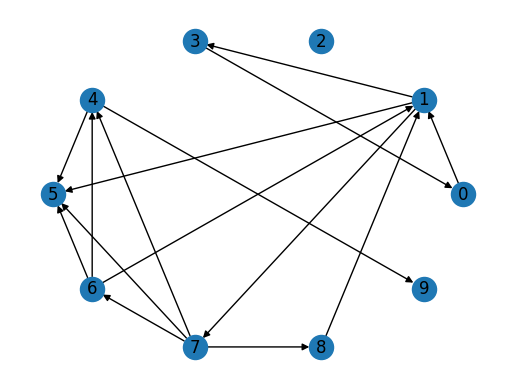

In [13]:
n_nodes = 10
graph_gen = DirectedGraphGenerator(
    nodes = n_nodes,
    expected_density = 2, 
    enforce_dag=False
)

graph = graph_gen()

pos = nx.circular_layout(graph)

fig, axs = plt.subplots(1)

nx.draw(graph, pos=pos, with_labels=True, ax=axs)

In [25]:
sem = linearSEM(
    graph=graph,
    abs_weight_low=0.6,
    noise_scale=0.1,
    contractive=True
)

intervention_targets = [[i] for i in range(n_nodes)]
intervention_datasets = list()

n_samples = 500

for target in intervention_targets:
    intervention_datasets.append(
        sem.generateData(n_samples=n_samples, intervention_set=target)
    )

In [26]:
mod_graph = mgraph(
    obs_graph=graph,
    sem=sem,
    missing_model='obs-only',
    p=0.1, 
    max_variance=0.1,
    is_mcar=False,
    max_child=2
)

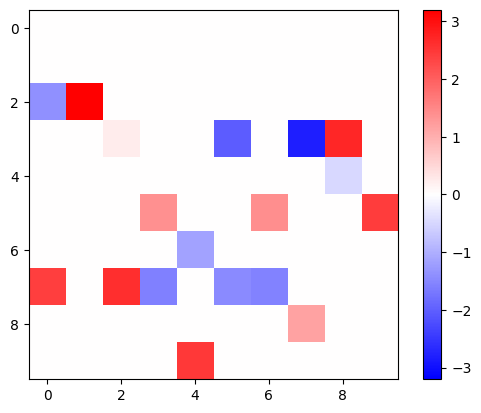

In [27]:
fig, axs = plt.subplots(1)

vmax = np.abs(mod_graph.m_coefs).max()
im = axs.imshow(mod_graph.m_coefs, vmin=-vmax, vmax=vmax, cmap='bwr')

_ = fig.colorbar(im)

## Testing Missforest and Optimal transport imputation

Impute the missing data using either missforest or optimal transport based imputation

In [28]:
missing_datasets = list()
missing_masks = list()

for targets, dataset in zip(intervention_targets, intervention_datasets):
    missing_mask, dataset_missing = mod_graph.generatemDataFromSamples(
        X=dataset,
        intervention_set=targets
    )

    missing_datasets.append(dataset_missing)
    missing_masks.append(missing_mask)

final_dataset = np.vstack(tuple(missing_datasets))
final_missing_masks = np.vstack(tuple(missing_masks))

In [29]:
impute_method = "missforest" 

if impute_method == "missforest":
    imp_dataset = missforest_impute(final_dataset, final_missing_masks)
elif impute_method == "optransport":
    imp_dataset = OT_impute(final_dataset, final_missing_masks)

final_datasets = [imp_dataset[i*n_samples:(i+1)*n_samples] for i in range(len(intervention_targets))]

intervention_datasets = [
    (final_datasets[i], missing_masks[i], missing_datasets[i]) for i in range(len(intervention_targets))
]

/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 0


/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 1


/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 2


/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 3


/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 4


/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/murali/miniconda3/envs/missnodag/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 5


In [30]:
training_dataset = missing_value_dataset(intervention_datasets, intervention_targets)

## Initialize NODAGS-Flow

In [31]:
causal_mech = gumbelSoftMLP(
    n_nodes=n_nodes, 
    lip_constant=0.9
)

nodags = iResBlock(
    func=causal_mech, 
    n_power_series=None, 
    precondition=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nodags = nodags.to(device)

miss_model = missModel(nodags, is_mcar=False)

## Training

In [32]:
model_trainer = Trainer(
    miss_model=miss_model,
    lr=1e-1,
    lambda_c=1e-2,
    max_epochs=30,
    batch_size=1024,
    n_lip_iters=5
)

In [33]:
log_px, iter_count, acceptance_rate, repetitions_list = model_trainer.train(
    data=training_dataset,
    print_loss=True, 
    print_interval=100,
    data_missing=False, # Set to False since we already imputed the missing values
    min_accept_factor=0.5
)

Text(0.5, 1.0, 'Estimated')

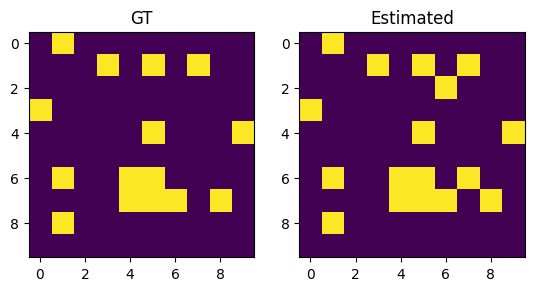

In [35]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.abs(sem.weights) > 0)
axs[0].set_title("GT")

axs[1].imshow(nodags.get_w_adj() > 0.75)
axs[1].set_title("Estimated")